$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import glob
import numpy as np

In [2]:
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posterior data

In [8]:
logM_posteriors = []
for fpost in glob.glob(os.path.join(dat_dir, 'provabgs-*hdf5'))[:3]: 
    f = h5py.File(fpost, 'r')
    mcmc = f['samples'][...][:,-100:,:,0]
    
    logM_posteriors.append(mcmc.reshape((mcmc.shape[0], mcmc.shape[1] * mcmc.shape[2])))
logM_posteriors = np.concatenate(logM_posteriors, axis=0)

In [9]:
print(logM_posteriors.shape[0])

1222


(8.0, 12.5)

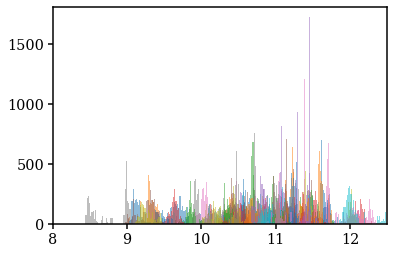

In [10]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=100, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=40, alpha=0.5)
plt.xlim(8., 12.5)

# estimate $p(M_* | \{x_i, z_i \})$ using NDE

In [11]:
x_data = torch.tensor(logM_posteriors.astype(np.float32)).to(device)
avg_post = torch.mean(x_data)
std_post = torch.std(x_data)
w_post = (x_data - avg_post)/std_post

In [12]:
batch_size = 256
Ntrain = int(0.8 * w_post.shape[0])
Nvalid = int(0.1 * w_post.shape[0])

trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(w_post[:Ntrain]),
        batch_size=batch_size,
        shuffle=False)

validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(w_post[Ntrain:Ntrain+Nvalid]),
        batch_size=batch_size)

In [13]:
def Loss(flow, post): 
    return -torch.sum(torch.logsumexp(flow.log_prob(post.flatten()[:,None]).reshape(post.shape), axis=1))

In [14]:
ndim = 1 

In [15]:
nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

blocks = []
for iblock in range(5): 
    blocks += [
        transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
        transforms.RandomPermutation(features=ndim)
    ]

transform = transforms.CompositeTransform(blocks)

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[ndim])

In [21]:
all_flows = []

lr = 1e-4
num_iter = 1000
patience = 20

best_valid_losses, valid_losseses = [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    print('5x%i' % nhidden)
    blocks = []
    for iblock in range(5): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
            transforms.RandomPermutation(features=ndim)
        ]
    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])

    # Combine into a flow.
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # parameters = [weights, means, stdevs]
    optimizer1 = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer1, lr, total_steps=num_iter)

    best_epoch = 0 
    best_valid_loss = np.inf
    valid_losses = []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in trainloader: 
            optimizer1.zero_grad()
            loss = Loss(flow, batch[0])
            loss.backward()
            train_loss += loss.item()
            optimizer1.step()
        train_loss /= len(trainloader.dataset)

        with torch.no_grad():
            valid_loss = 0.
            for batch in validloader: 
                loss = Loss(flow, batch[0])
                valid_loss += loss.item()
            valid_loss /= len(validloader.dataset)           
            valid_losses.append(valid_loss)
            
            if epoch % 20 == 0: 
                print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
                    
        scheduler.step()
    all_flows.append(flow)
    valid_losseses.append(valid_losses)   
    best_valid_losses.append(best_valid_loss)

5x245
0 	 -5.56e+00 	 -5.57e+00
20 	 -6.14e+00 	 -6.15e+00
40 	 -6.60e+00 	 -6.52e+00
>>>58 	 -6.52642e+00
5x113
0 	 -5.65e+00 	 -5.65e+00
20 	 -5.88e+00 	 -5.88e+00
40 	 -6.21e+00 	 -6.21e+00
60 	 -6.58e+00 	 -6.52e+00
80 	 -6.60e+00 	 -6.52e+00
>>>84 	 -6.52659e+00
5x75
0 	 -4.47e+00 	 -4.48e+00
20 	 -4.65e+00 	 -4.66e+00
40 	 -4.92e+00 	 -4.93e+00
60 	 -5.41e+00 	 -5.43e+00
80 	 -6.18e+00 	 -6.19e+00
100 	 -6.60e+00 	 -6.52e+00
>>>116 	 -6.52660e+00
5x135
0 	 -5.02e+00 	 -5.03e+00
20 	 -5.34e+00 	 -5.34e+00
40 	 -5.83e+00 	 -5.85e+00
60 	 -6.53e+00 	 -6.49e+00
80 	 -6.60e+00 	 -6.52e+00
>>>85 	 -6.52634e+00
5x158
0 	 -4.21e+00 	 -4.22e+00
20 	 -4.64e+00 	 -4.66e+00
40 	 -5.35e+00 	 -5.37e+00
60 	 -6.48e+00 	 -6.45e+00
80 	 -6.60e+00 	 -6.52e+00
100 	 -6.60e+00 	 -6.52e+00
>>>100 	 -6.52200e+00


(0.0, 117.0)

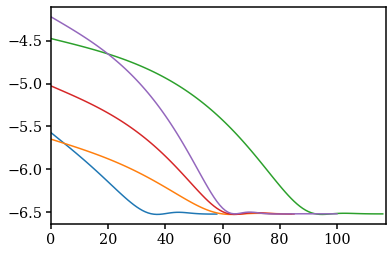

In [26]:
for vl in valid_losseses: 
    plt.plot(np.array(vl))
#plt.ylim(1e4, 2e4)
plt.xlim(0, np.max([len(vl) for vl in valid_losseses]))

In [29]:
#i_best = np.argmin(best_valid_losses)
i_best = 2
print(i_best)

2


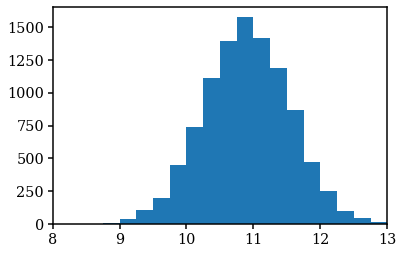

In [30]:
with torch.no_grad(): 
    w_prime = all_flows[i_best].sample(10000)
    post_prime = w_prime * std_post + avg_post
    
plt.hist(np.array(post_prime.detach().cpu()), range=(8., 13.), bins=20)
plt.xlim(8., 13.)
plt.show()